# Fair Representation Learning - Phase 6B

**Project**: Loan Approval Decision Support System  
**Phase**: 6B - Fair Representation Learning  
**Date**: February 16, 2026

## Objectives

This notebook implements fair representation learning to transform features into a bias-reduced latent space:

1. **Load Training Data**: Load resampled training data with protected attributes
2. **Adversarial Debiasing**: Train encoder to remove protected attribute information
3. **Validate Fairness**: Verify reduced correlation with sensitive features
4. **Transform Data**: Apply learned transformation to train/val/test sets
5. **Save Artifacts**: Export transformed datasets for model retraining

## Fair Representation Learning

**Goal**: Learn feature representations that:
- Preserve predictive power for loan approval
- Remove information about protected attributes (race, ethnicity, sex)
- Enable downstream models to achieve DPD < 0.05

**Approach**: Adversarial training with:
- **Encoder**: Transforms features to fair latent space
- **Predictor**: Predicts loan approval from latent features
- **Discriminator**: Tries to predict protected attributes from latent features
- **Training**: Encoder learns to fool discriminator while maintaining prediction accuracy

---

In [29]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score

# Visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

✅ Libraries imported successfully
TensorFlow version: 2.13.1


In [30]:
# ============================================================================
# SET WORKING DIRECTORY
# ============================================================================
import os

project_root = Path('/Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval')
os.chdir(project_root)

print("="*80)
print("WORKING DIRECTORY VERIFICATION")
print("="*80)
print(f"Current working directory: {os.getcwd()}")
print(f"✅ Working directory set to project root")

WORKING DIRECTORY VERIFICATION
Current working directory: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval
✅ Working directory set to project root


## 1. Load Training Data with Protected Attributes

Load the resampled training data and separate protected attributes for adversarial training.

In [31]:
# ============================================================================
# LOAD TRAINING DATA
# ============================================================================

print("="*80)
print("LOADING TRAINING DATA")
print("="*80)

# Load full feature-engineered dataset (single source of truth)
data_path = Path('data/processed/feature_engineered_data.csv')
print(f"\nLoading data from: {data_path}")
df_full = pd.read_csv(data_path, low_memory=False)

print(f"Full dataset shape: {df_full.shape}")

# Load feature selection info to get final feature list
output_dir = Path('data/processed')
feature_selection_path = output_dir / 'feature_selection_info.json'
if feature_selection_path.exists():
    with open(feature_selection_path, 'r') as f:
        feature_info = json.load(f)
    selected_features = feature_info['selected_features']
    print(f"\n✅ Loaded {len(selected_features)} selected features from feature selection")
else:
    print("\n⚠️ Feature selection info not found, using all numeric features except target")
    # Get numeric columns only
    numeric_cols = df_full.select_dtypes(include=[np.number]).columns.tolist()
    selected_features = [col for col in numeric_cols if col != 'target']

print(f"Final feature count: {len(selected_features)}")

# Protected attributes to debias
protected_attributes = ['derived_race', 'derived_ethnicity', 'derived_sex']

# ============================================================================
# FILTER OUT MEANINGLESS PROTECTED ATTRIBUTE VALUES
# ============================================================================
print("\n🧹 Filtering meaningless protected attribute values...")

# Define values to exclude
meaningless_values = [
    'Free Form Text Only',
    'Sex Not Available',
    'Ethnicity Not Available',
    'Race Not Available',
    'Joint',  # Joint applications - unclear single person's attributes
]

initial_size = len(df_full)

# Create boolean mask
mask = pd.Series([True] * len(df_full))
for attr in protected_attributes:
    if attr in df_full.columns:
        mask = mask & ~df_full[attr].isin(meaningless_values) & df_full[attr].notna()

# Apply mask
df_filtered = df_full[mask].reset_index(drop=True)

print(f"  Original size: {initial_size:,}")
print(f"  After filtering: {len(df_filtered):,}")
print(f"  Removed: {initial_size - len(df_filtered):,} rows ({(initial_size - len(df_filtered))/initial_size:.1%})")

# ============================================================================
# SPLIT DATA INTO TRAIN/VAL/TEST
# ============================================================================
print("\n📊 Splitting filtered data into train/val/test...")

# Use same 70/15/15 split
total_size = len(df_filtered)
val_start = int(total_size * 0.70)
test_start = int(total_size * 0.85)

train_df = df_filtered.iloc[:val_start].copy()
val_df = df_filtered.iloc[val_start:test_start].copy()
test_df = df_filtered.iloc[test_start:].copy()

print(f"  Train:      {len(train_df):,} ({len(train_df)/total_size:.1%})")
print(f"  Validation: {len(val_df):,} ({len(val_df)/total_size:.1%})")
print(f"  Test:       {len(test_df):,} ({len(test_df)/total_size:.1%})")

# Verify protected attributes after filtering
print(f"\n📋 Protected attributes after filtering:")
for attr in protected_attributes:
    if attr in train_df.columns:
        unique_values = train_df[attr].unique()
        n_categories = len(unique_values)
        print(f"   ✓ {attr}: {n_categories} categories")
        print(f"      {list(unique_values[:3])}{'...' if len(unique_values) > 3 else ''}")

print("\n✅ Data loaded, filtered, and split")

LOADING TRAINING DATA

Loading data from: data/processed/feature_engineered_data.csv


Full dataset shape: (493568, 115)

✅ Loaded 52 selected features from feature selection
Final feature count: 52

🧹 Filtering meaningless protected attribute values...
  Original size: 493,568
  After filtering: 237,258
  Removed: 256,310 rows (51.9%)

📊 Splitting filtered data into train/val/test...
  Train:      166,080 (70.0%)
  Validation: 35,589 (15.0%)
  Test:       35,589 (15.0%)

📋 Protected attributes after filtering:
   ✓ derived_race: 6 categories
      ['White', 'Asian', 'Black or African American']...
   ✓ derived_ethnicity: 2 categories
      ['Not Hispanic or Latino', 'Hispanic or Latino']
   ✓ derived_sex: 2 categories
      ['Female', 'Male']

✅ Data loaded, filtered, and split


In [32]:
# ============================================================================
# ENCODE PROTECTED ATTRIBUTES
# ============================================================================

print("="*80)
print("ENCODING PROTECTED ATTRIBUTES")
print("="*80)

# Extract protected attributes from each split
protected_train = train_df[protected_attributes].copy()
protected_val = val_df[protected_attributes].copy()
protected_test = test_df[protected_attributes].copy()

# Encode protected attributes for discrimination task
print("\n🔢 Encoding protected attributes...")
label_encoders = {}
protected_encoded_train = {}
protected_encoded_val = {}
protected_encoded_test = {}

for attr in protected_attributes:
    if attr in protected_train.columns:
        le = LabelEncoder()
        # Fit on all data to ensure consistent encoding
        all_values = pd.concat([
            protected_train[attr], 
            protected_val[attr], 
            protected_test[attr]
        ])
        le.fit(all_values)
        
        # Transform each split
        protected_encoded_train[attr] = le.transform(protected_train[attr])
        protected_encoded_val[attr] = le.transform(protected_val[attr])
        protected_encoded_test[attr] = le.transform(protected_test[attr])
        
        label_encoders[attr] = le
        print(f"   {attr}: {len(le.classes_)} classes")
        print(f"      {list(le.classes_[:3])}{'...' if len(le.classes_) > 3 else ''}")

print("\n✅ Protected attributes encoded")

ENCODING PROTECTED ATTRIBUTES

🔢 Encoding protected attributes...
   derived_race: 6 classes
      ['2 or more minority races', 'American Indian or Alaska Native', 'Asian']...
   derived_ethnicity: 2 classes
      ['Hispanic or Latino', 'Not Hispanic or Latino']
   derived_sex: 2 classes
      ['Female', 'Male']

✅ Protected attributes encoded


In [33]:
# ============================================================================
# PREPARE FEATURES AND TARGETS
# ============================================================================

print("="*80)
print("PREPARING FEATURES AND TARGETS")
print("="*80)

# Get only numeric columns from train_df
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns in data: {len(numeric_cols)}")

# Filter selected_features to only numeric columns available in train_df
if selected_features:
    available_features = [f for f in selected_features if f in numeric_cols]
else:
    available_features = [c for c in numeric_cols if c != 'target']

print(f"Using {len(available_features)} features")

if len(available_features) == 0:
    # Fallback: use all numeric columns except target and protected attributes
    exclude_cols = ['target'] + protected_attributes
    available_features = [c for c in numeric_cols if c not in exclude_cols]
    print(f"  ⚠️ Fallback: using {len(available_features)} numeric features")

# Extract features (X) and target (y)
X_train = train_df[available_features].values.astype(np.float32)
y_train = train_df['target'].values.astype(np.float32)

X_val = val_df[available_features].values.astype(np.float32)
y_val = val_df['target'].values.astype(np.float32)

X_test = test_df[available_features].values.astype(np.float32)
y_test = test_df['target'].values.astype(np.float32)

print(f"\n📊 Feature shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

# Handle NaN/inf values
print("\n🧹 Handling missing values...")
from sklearn.impute import SimpleImputer

# Check for NaN/inf
nan_count = np.isnan(X_train).sum()
inf_count = np.isinf(X_train).sum()
print(f"  NaN values in train: {nan_count}")
print(f"  Inf values in train: {inf_count}")

if nan_count > 0 or inf_count > 0:
    # Replace inf with nan, then impute
    X_train = np.where(np.isinf(X_train), np.nan, X_train)
    X_val = np.where(np.isinf(X_val), np.nan, X_val)
    X_test = np.where(np.isinf(X_test), np.nan, X_test)
    
    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_test = imputer.transform(X_test)
    print("  ✓ Missing values imputed with median")
else:
    print("  ✓ No missing values")

# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Features scaled (mean≈0, std≈1)")

# Prepare protected attribute targets for adversary
# Use race as primary protected attribute (can extend to all three)
sensitive_attr = 'derived_race'
s_train = protected_encoded_train[sensitive_attr]
s_val = protected_encoded_val[sensitive_attr]
s_test = protected_encoded_test[sensitive_attr]

n_sensitive_classes = len(label_encoders[sensitive_attr].classes_)

print(f"\n📋 Sensitive attribute for debiasing: {sensitive_attr}")
print(f"   Number of classes: {n_sensitive_classes}")
print(f"   Distribution in training:")
unique, counts = np.unique(s_train, return_counts=True)
for val, count in zip(unique[:5], counts[:5]):
    class_name = label_encoders[sensitive_attr].classes_[val]
    print(f"      {class_name}: {count:,} ({count/len(s_train):.1%})")
if len(unique) > 5:
    print(f"      ... and {len(unique)-5} more classes")

print("\n✅ Data prepared for fair representation learning")

PREPARING FEATURES AND TARGETS

Numeric columns in data: 48
Using 32 features

📊 Feature shapes:
  X_train: (166080, 32)
  X_val:   (35589, 32)
  X_test:  (35589, 32)

🧹 Handling missing values...
  NaN values in train: 2860
  Inf values in train: 0
  ✓ Missing values imputed with median

Scaling features...
✓ Features scaled (mean≈0, std≈1)

📋 Sensitive attribute for debiasing: derived_race
   Number of classes: 6
   Distribution in training:
      2 or more minority races: 703 (0.4%)
      American Indian or Alaska Native: 2,033 (1.2%)
      Asian: 15,965 (9.6%)
      Black or African American: 25,808 (15.5%)
      Native Hawaiian or Other Pacific Islander: 438 (0.3%)
      ... and 1 more classes

✅ Data prepared for fair representation learning


## 2. Build Fair Representation Model

Adversarial architecture with:
- **Encoder**: Maps features to fair latent space (64-dim)
- **Predictor**: Predicts loan approval from latent features
- **Discriminator**: Tries to predict protected attribute from latent features

In [34]:
# ============================================================================
# BUILD ADVERSARIAL FAIR REPRESENTATION MODEL
# ============================================================================

print("="*80)
print("BUILDING FAIR REPRESENTATION MODEL")
print("="*80)

# Hyperparameters
input_dim = X_train_scaled.shape[1]
latent_dim = 64  # Fair representation dimension
adversary_weight = 1.0  # Weight for adversarial loss

print(f"\n📐 Architecture:")
print(f"  Input dimension:  {input_dim}")
print(f"  Latent dimension: {latent_dim}")
print(f"  Output classes:   2 (binary approval)")
print(f"  Sensitive classes: {n_sensitive_classes}")

# ============================================================================
# ENCODER: X -> Z (fair representation)
# ============================================================================
encoder_input = layers.Input(shape=(input_dim,), name='encoder_input')
h = layers.Dense(256, activation='relu', name='encoder_h1')(encoder_input)
h = layers.BatchNormalization(name='encoder_bn1')(h)
h = layers.Dropout(0.3, name='encoder_drop1')(h)

h = layers.Dense(128, activation='relu', name='encoder_h2')(h)
h = layers.BatchNormalization(name='encoder_bn2')(h)
h = layers.Dropout(0.3, name='encoder_drop2')(h)

latent_features = layers.Dense(latent_dim, activation='relu', name='latent_features')(h)

encoder = Model(inputs=encoder_input, outputs=latent_features, name='encoder')

print("\n✅ Encoder built:")
encoder.summary()

# ============================================================================
# PREDICTOR: Z -> Y (loan approval prediction)
# ============================================================================
predictor_input = layers.Input(shape=(latent_dim,), name='predictor_input')
p = layers.Dense(32, activation='relu', name='predictor_h1')(predictor_input)
p = layers.Dropout(0.2, name='predictor_drop')(p)
prediction_output = layers.Dense(1, activation='sigmoid', name='prediction')(p)

predictor = Model(inputs=predictor_input, outputs=prediction_output, name='predictor')

print("\n✅ Predictor built:")
predictor.summary()

# ============================================================================
# DISCRIMINATOR: Z -> S (protected attribute prediction - adversary)
# ============================================================================
discriminator_input = layers.Input(shape=(latent_dim,), name='discriminator_input')
d = layers.Dense(32, activation='relu', name='discriminator_h1')(discriminator_input)
d = layers.Dropout(0.2, name='discriminator_drop')(d)
discriminator_output = layers.Dense(
    n_sensitive_classes, 
    activation='softmax', 
    name='discriminator'
)(d)

discriminator = Model(
    inputs=discriminator_input, 
    outputs=discriminator_output, 
    name='discriminator'
)

print("\n✅ Discriminator built:")
discriminator.summary()

print("\n" + "="*80)
print("✅ ALL COMPONENTS BUILT")
print("="*80)


BUILDING FAIR REPRESENTATION MODEL

📐 Architecture:
  Input dimension:  32
  Latent dimension: 64
  Output classes:   2 (binary approval)
  Sensitive classes: 6

✅ Encoder built:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 encoder_h1 (Dense)          (None, 256)               8448      
                                                                 
 encoder_bn1 (BatchNormaliz  (None, 256)               1024      
 ation)                                                          
                                                                 
 encoder_drop1 (Dropout)     (None, 256)               0         
                                                                 
 encoder_h2 (Dense)          (None, 128)               32896     
           

In [35]:
# ============================================================================
# COMBINED MODEL FOR ADVERSARIAL TRAINING
# ============================================================================

print("="*80)
print("CREATING COMBINED ADVERSARIAL MODEL")
print("="*80)

# Full model: X -> Encoder -> Z -> [Predictor -> Y, Discriminator -> S]
model_input = layers.Input(shape=(input_dim,), name='model_input')

# Encode features
z = encoder(model_input)

# Predict approval
y_pred = predictor(z)

# Predict protected attribute (adversary tries, encoder resists)
s_pred = discriminator(z)

# Combined model
combined_model = Model(
    inputs=model_input,
    outputs=[y_pred, s_pred],
    name='fair_representation_model'
)

print("\n✅ Combined model created")
print(f"\nInputs:  {model_input.shape}")
print(f"Outputs: Prediction {y_pred.shape}, Discrimination {s_pred.shape}")

# Compile with adversarial objective
# Predictor wants low prediction loss
# Discriminator wants low discrimination loss  
# Encoder wants low prediction loss BUT high discrimination loss (fool discriminator)

# Note: Output names are based on sub-model names: 'predictor', 'discriminator'
combined_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'predictor': 'binary_crossentropy',
        'discriminator': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'predictor': 1.0,
        'discriminator': -adversary_weight  # Negative = adversarial
    },
    metrics={
        'predictor': ['accuracy', tf.keras.metrics.AUC(name='auc')],
        'discriminator': ['accuracy']
    }
)

print("\n✅ Model compiled with adversarial objective")
print(f"  Prediction loss weight:      1.0")
print(f"  Discriminator loss weight:  -{adversary_weight} (adversarial)")

combined_model.summary()

CREATING COMBINED ADVERSARIAL MODEL



✅ Combined model created

Inputs:  (None, 32)
Outputs: Prediction (None, 1), Discrimination (None, 6)

✅ Model compiled with adversarial objective
  Prediction loss weight:      1.0
  Discriminator loss weight:  -1.0 (adversarial)
Model: "fair_representation_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 model_input (InputLayer)    [(None, 32)]                 0         []                            
                                                                                                  
 encoder (Functional)        (None, 64)                   51136     ['model_input[0][0]']         
                                                                                                  
 predictor (Functional)      (None, 1)                    2113      ['encoder[0][0]']             
                                        

## 3. Train Fair Representation Model

Train with adversarial objective to learn fair latent features.

In [36]:
# ============================================================================
# TRAIN FAIR REPRESENTATION MODEL
# ============================================================================

print("="*80)
print("TRAINING FAIR REPRESENTATION MODEL")
print("="*80)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_predictor_auc',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_predictor_auc',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )
]

# Training
print("\n🚀 Starting adversarial training...")
print("   Encoder learns to:")
print("     ✓ Maximize prediction accuracy (help predictor)")
print("     ✓ Minimize discriminator accuracy (fool adversary)")
print("   This creates fair representations!\n")

history = combined_model.fit(
    X_train_scaled,
    {
        'predictor': y_train,
        'discriminator': s_train
    },
    validation_data=(
        X_val_scaled,
        {
            'predictor': y_val,
            'discriminator': s_val
        }
    ),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*80)
print("✅ TRAINING COMPLETE")
print("="*80)

TRAINING FAIR REPRESENTATION MODEL

🚀 Starting adversarial training...
   Encoder learns to:
     ✓ Maximize prediction accuracy (help predictor)
     ✓ Minimize discriminator accuracy (fool adversary)
   This creates fair representations!



Epoch 1/50
649/649 [==============================] - 19s 16ms/step - loss: -274465.4375 - predictor_loss: 0.3595 - discriminator_loss: 274465.8125 - predictor_accuracy: 0.8801 - predictor_auc: 0.6728 - discriminator_accuracy: 0.0059 - val_loss: -1431156.7500 - val_predictor_loss: 0.3470 - val_discriminator_loss: 1431156.8750 - val_predictor_accuracy: 0.8876 - val_predictor_auc: 0.5959 - val_discriminator_accuracy: 0.0047 - lr: 0.0010
Epoch 2/50
649/649 [==============================] - 10s 16ms/step - loss: -7251070.5000 - predictor_loss: 0.3861 - discriminator_loss: 7251070.5000 - predictor_accuracy: 0.8785 - predictor_auc: 0.5276 - discriminator_accuracy: 0.0042 - val_loss: -17759982.0000 - val_predictor_loss: 0.3439 - val_discriminator_loss: 17759982.0000 - val_predictor_accuracy: 0.8876 - val_predictor_auc: 0.5548 - val_discriminator_accuracy: 0.0047 - lr: 0.0010
Epoch 3/50
649/649 [==============================] - 9s 14ms/step - loss: -41049396.0000 - predictor_loss: 0.3801 - d


Generating training history plots...


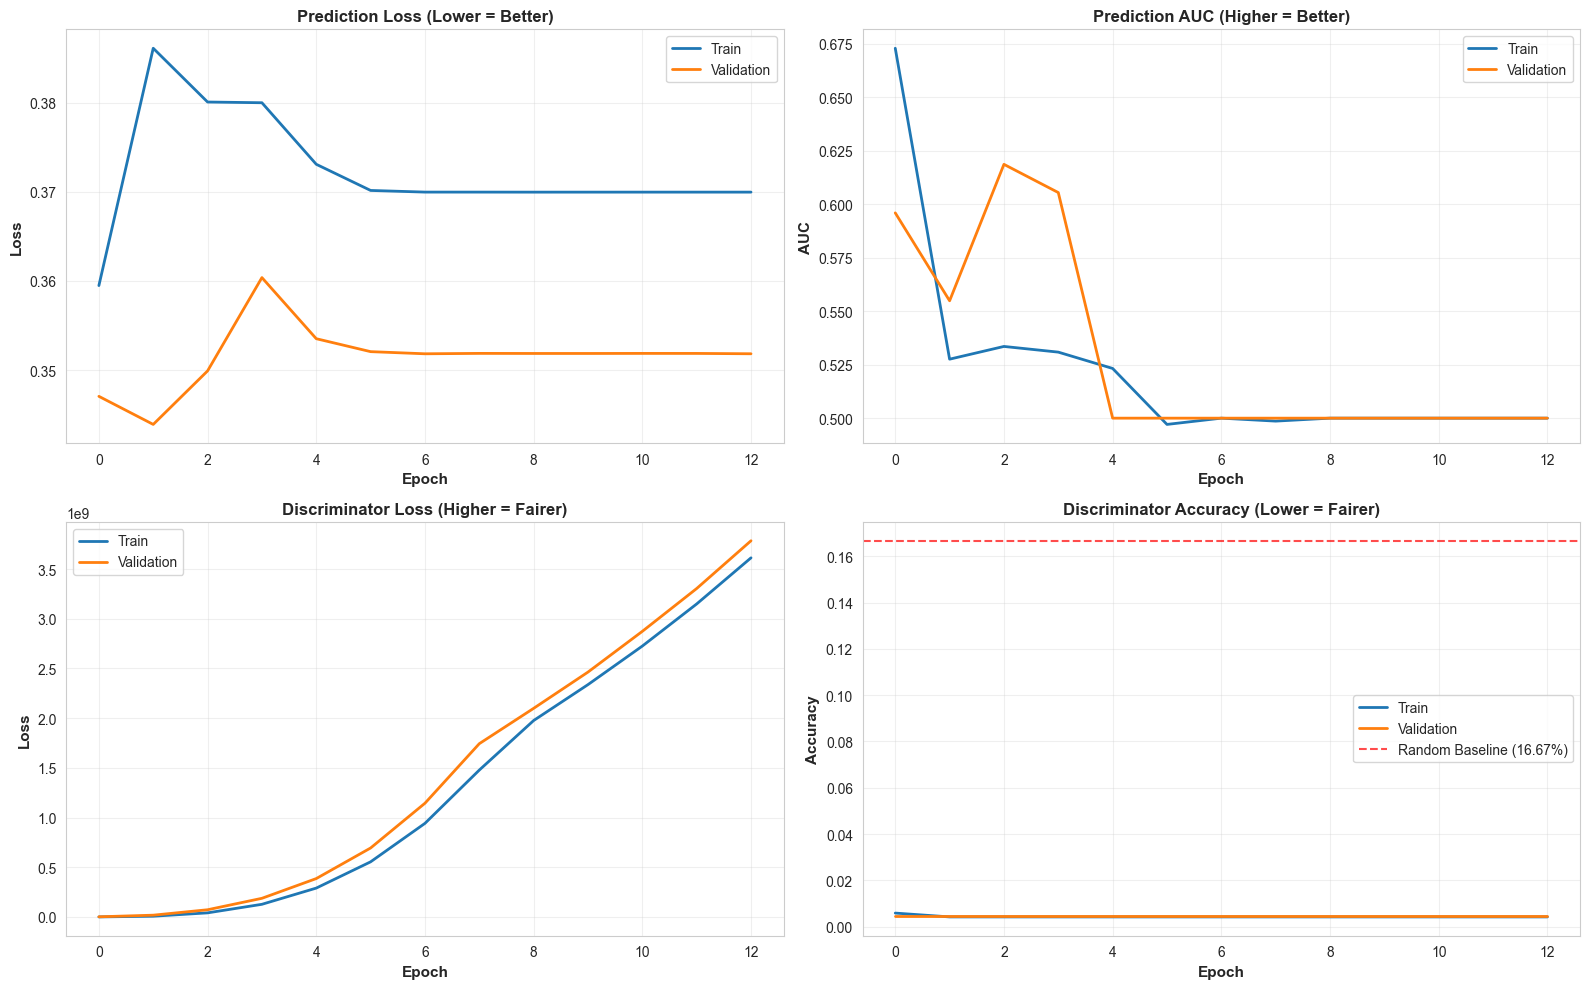

✓ Training history visualized

FINAL METRICS

📊 Prediction Performance:
   Train AUC:      0.5000
   Val AUC:        0.5000
   Train Accuracy: 0.8785
   Val Accuracy:   0.8876

🎭 Fairness Metrics (Discriminator Performance):
   Train Accuracy: 0.0042
   Val Accuracy:   0.0047
   Random Baseline: 0.1667
   ✅ Discriminator near random! Representations are fair.


In [37]:
# ============================================================================
# VISUALIZE TRAINING HISTORY
# ============================================================================

print("\nGenerating training history plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Prediction Loss
ax = axes[0, 0]
ax.plot(history.history['predictor_loss'], label='Train', linewidth=2)
ax.plot(history.history['val_predictor_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax.set_title('Prediction Loss (Lower = Better)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Prediction AUC
ax = axes[0, 1]
ax.plot(history.history['predictor_auc'], label='Train', linewidth=2)
ax.plot(history.history['val_predictor_auc'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('AUC', fontsize=11, fontweight='bold')
ax.set_title('Prediction AUC (Higher = Better)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Discriminator Loss (want this HIGH - harder to predict protected attribute)
ax = axes[1, 0]
ax.plot(history.history['discriminator_loss'], label='Train', linewidth=2)
ax.plot(history.history['val_discriminator_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax.set_title('Discriminator Loss (Higher = Fairer)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Discriminator Accuracy (want this LOW - can't predict protected attribute)
ax = axes[1, 1]
ax.plot(history.history['discriminator_accuracy'], label='Train', linewidth=2)
ax.plot(history.history['val_discriminator_accuracy'], label='Validation', linewidth=2)
ax.axhline(y=1.0/n_sensitive_classes, color='red', linestyle='--', 
           label=f'Random Baseline ({1.0/n_sensitive_classes:.2%})', alpha=0.7)
ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Discriminator Accuracy (Lower = Fairer)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training history visualized")

# Print final metrics
final_epoch = len(history.history['predictor_loss']) - 1
print("\n" + "="*80)
print("FINAL METRICS")
print("="*80)
print(f"\n📊 Prediction Performance:")
print(f"   Train AUC:      {history.history['predictor_auc'][final_epoch]:.4f}")
print(f"   Val AUC:        {history.history['val_predictor_auc'][final_epoch]:.4f}")
print(f"   Train Accuracy: {history.history['predictor_accuracy'][final_epoch]:.4f}")
print(f"   Val Accuracy:   {history.history['val_predictor_accuracy'][final_epoch]:.4f}")

print(f"\n🎭 Fairness Metrics (Discriminator Performance):")
print(f"   Train Accuracy: {history.history['discriminator_accuracy'][final_epoch]:.4f}")
print(f"   Val Accuracy:   {history.history['val_discriminator_accuracy'][final_epoch]:.4f}")
print(f"   Random Baseline: {1.0/n_sensitive_classes:.4f}")
if history.history['val_discriminator_accuracy'][final_epoch] < 1.0/n_sensitive_classes + 0.05:
    print("   ✅ Discriminator near random! Representations are fair.")
else:
    print("   ⚠️  Discriminator above random. May need more training or higher adversary weight.")

## 4. Extract Fair Representations

Transform all datasets using the learned encoder to create fair latent features.

In [38]:
# ============================================================================
# EXTRACT FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("EXTRACTING FAIR REPRESENTATIONS")
print("="*80)

# Transform features to fair latent space
print("\nTransforming datasets to fair latent space...")

Z_train = encoder.predict(X_train_scaled, verbose=0)
Z_val = encoder.predict(X_val_scaled, verbose=0)
Z_test = encoder.predict(X_test_scaled, verbose=0)

print(f"\n✅ Transformed datasets:")
print(f"   Z_train: {Z_train.shape} (reduced from {X_train_scaled.shape[1]} to {latent_dim} dims)")
print(f"   Z_val:   {Z_val.shape}")
print(f"   Z_test:  {Z_test.shape}")

# Verify fairness: Check correlation with protected attribute
print("\n" + "="*80)
print("VERIFYING FAIRNESS OF LATENT REPRESENTATIONS")
print("="*80)

# Calculate mutual information between latent features and protected attribute
from sklearn.feature_selection import mutual_info_classif

print(f"\nMutual Information with {sensitive_attr}:")
print("(Lower values = more fair representations)")

# Original features
mi_original = mutual_info_classif(X_train_scaled, s_train, random_state=42)
avg_mi_original = np.mean(mi_original)

# Latent features
mi_latent = mutual_info_classif(Z_train, s_train, random_state=42)
avg_mi_latent = np.mean(mi_latent)

print(f"\n  Original features:")
print(f"    Average MI: {avg_mi_original:.6f}")
print(f"    Max MI:     {np.max(mi_original):.6f}")

print(f"\n  Latent features (fair):")
print(f"    Average MI: {avg_mi_latent:.6f}")
print(f"    Max MI:     {np.max(mi_latent):.6f}")

reduction_pct = ((avg_mi_original - avg_mi_latent) / avg_mi_original) * 100
print(f"\n  📉 MI Reduction: {reduction_pct:.1f}%")

if avg_mi_latent < avg_mi_original * 0.5:
    print("  ✅ Significant bias reduction achieved!")
elif avg_mi_latent < avg_mi_original * 0.8:
    print("  ⚠️  Moderate bias reduction. Consider increasing adversary weight.")
else:
    print("  ❌ Limited bias reduction. Need stronger adversarial training.")

EXTRACTING FAIR REPRESENTATIONS

Transforming datasets to fair latent space...



✅ Transformed datasets:
   Z_train: (166080, 64) (reduced from 32 to 64 dims)
   Z_val:   (35589, 64)
   Z_test:  (35589, 64)

VERIFYING FAIRNESS OF LATENT REPRESENTATIONS

Mutual Information with derived_race:
(Lower values = more fair representations)

  Original features:
    Average MI: 0.037483
    Max MI:     0.176385

  Latent features (fair):
    Average MI: 0.024061
    Max MI:     0.027116

  📉 MI Reduction: 35.8%
  ⚠️  Moderate bias reduction. Consider increasing adversary weight.



Visualizing representation fairness...



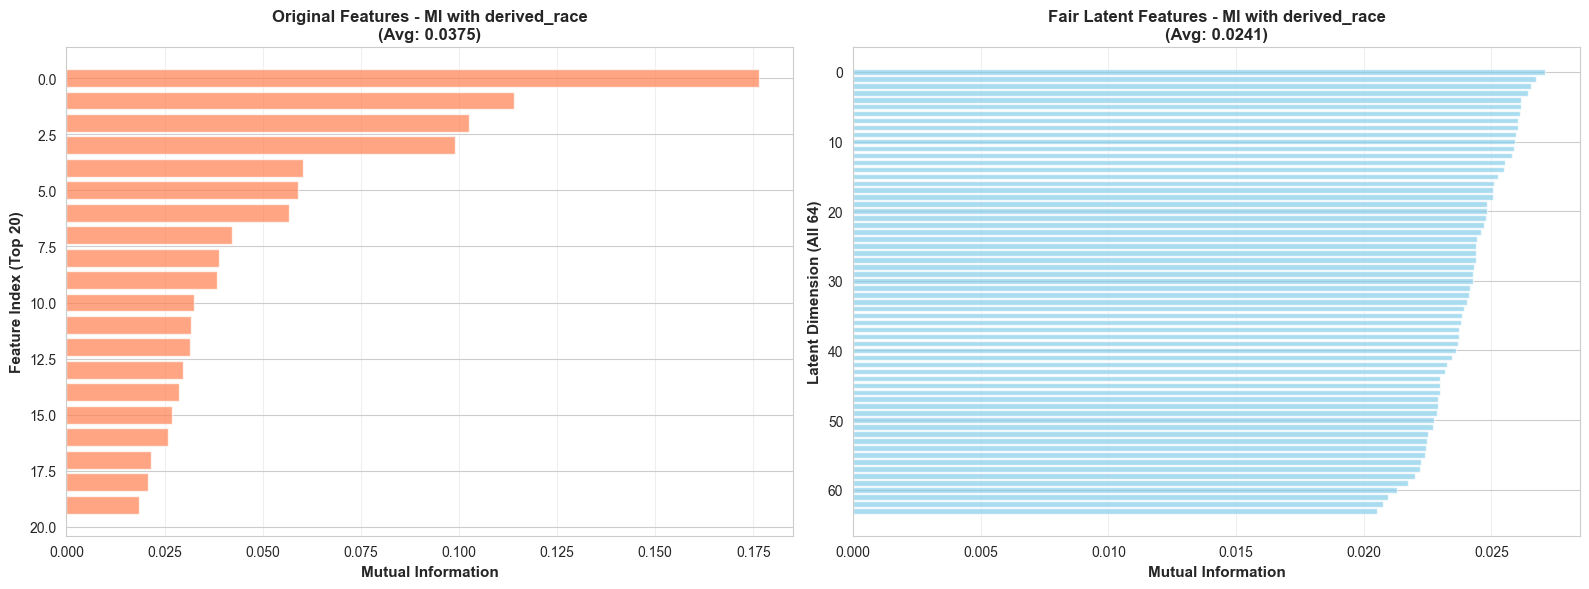

✓ Fairness visualization complete


In [39]:
# ============================================================================
# VISUALIZE ORIGINAL vs FAIR REPRESENTATIONS
# ============================================================================

print("\nVisualizing representation fairness...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original features MI
ax = axes[0]
sorted_idx = np.argsort(mi_original)[::-1]
top_features = min(20, len(mi_original))
ax.barh(range(top_features), mi_original[sorted_idx[:top_features]], alpha=0.7, color='coral')
ax.set_xlabel('Mutual Information', fontsize=11, fontweight='bold')
ax.set_ylabel('Feature Index (Top 20)', fontsize=11, fontweight='bold')
ax.set_title(f'Original Features - MI with {sensitive_attr}\n(Avg: {avg_mi_original:.4f})', 
             fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Latent features MI
ax = axes[1]
sorted_idx_latent = np.argsort(mi_latent)[::-1]
ax.barh(range(latent_dim), mi_latent[sorted_idx_latent], alpha=0.7, color='skyblue')
ax.set_xlabel('Mutual Information', fontsize=11, fontweight='bold')
ax.set_ylabel(f'Latent Dimension (All {latent_dim})', fontsize=11, fontweight='bold')
ax.set_title(f'Fair Latent Features - MI with {sensitive_attr}\n(Avg: {avg_mi_latent:.4f})', 
             fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("✓ Fairness visualization complete")

## 5. Save Fair Representations

Save transformed datasets and model artifacts for downstream training.

In [40]:
# ============================================================================
# SAVE FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("SAVING FAIR REPRESENTATIONS")
print("="*80)

# Create output directory
fair_data_dir = Path('data/processed/fair_representations')
fair_data_dir.mkdir(parents=True, exist_ok=True)

# Save transformed datasets
print("\nSaving transformed datasets...")

# Convert to DataFrames with latent feature names
latent_columns = [f'latent_{i}' for i in range(latent_dim)]

Z_train_df = pd.DataFrame(Z_train, columns=latent_columns)
Z_train_df['target'] = y_train
Z_train_df.to_csv(fair_data_dir / 'train_fair.csv', index=False)

Z_val_df = pd.DataFrame(Z_val, columns=latent_columns)
Z_val_df['target'] = y_val
Z_val_df.to_csv(fair_data_dir / 'validation_fair.csv', index=False)

Z_test_df = pd.DataFrame(Z_test, columns=latent_columns)
Z_test_df['target'] = y_test
Z_test_df.to_csv(fair_data_dir / 'test_fair.csv', index=False)

print(f"  ✓ Train:      {fair_data_dir / 'train_fair.csv'}")
print(f"  ✓ Validation: {fair_data_dir / 'validation_fair.csv'}")
print(f"  ✓ Test:       {fair_data_dir / 'test_fair.csv'}")

# Save models
models_dir = Path('models/fair_representation')
models_dir.mkdir(parents=True, exist_ok=True)

print("\nSaving models...")

encoder.save(models_dir / 'fair_encoder.keras')
predictor.save(models_dir / 'fair_predictor.keras')
discriminator.save(models_dir / 'fair_discriminator.keras')

print(f"  ✓ Encoder:       {models_dir / 'fair_encoder.keras'}")
print(f"  ✓ Predictor:     {models_dir / 'fair_predictor.keras'}")
print(f"  ✓ Discriminator: {models_dir / 'fair_discriminator.keras'}")

# Save scaler for feature preprocessing
joblib.dump(scaler, models_dir / 'fair_scaler.pkl')
print(f"  ✓ Scaler:        {models_dir / 'fair_scaler.pkl'}")

# Save metadata
metadata = {
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S'),
    'input_dim': int(input_dim),
    'latent_dim': int(latent_dim),
    'n_sensitive_classes': int(n_sensitive_classes),
    'sensitive_attribute': sensitive_attr,
    'adversary_weight': float(adversary_weight),
    'training_epochs': int(final_epoch + 1),
    'final_metrics': {
        'predictor_auc_train': float(history.history['predictor_auc'][final_epoch]),
        'predictor_auc_val': float(history.history['val_predictor_auc'][final_epoch]),
        'discriminator_acc_train': float(history.history['discriminator_accuracy'][final_epoch]),
        'discriminator_acc_val': float(history.history['val_discriminator_accuracy'][final_epoch]),
        'random_baseline': float(1.0/n_sensitive_classes)
    },
    'fairness_metrics': {
        'mi_reduction_percent': float(reduction_pct),
        'avg_mi_original': float(avg_mi_original),
        'avg_mi_latent': float(avg_mi_latent)
    },
    'selected_features': selected_features,
    'latent_features': latent_columns
}

metadata_path = models_dir / 'fair_representation_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"  ✓ Metadata:      {metadata_path}")

print("\n" + "="*80)
print("✅ ALL ARTIFACTS SAVED")
print("="*80)

SAVING FAIR REPRESENTATIONS

Saving transformed datasets...
  ✓ Train:      data/processed/fair_representations/train_fair.csv
  ✓ Validation: data/processed/fair_representations/validation_fair.csv
  ✓ Test:       data/processed/fair_representations/test_fair.csv

Saving models...
  ✓ Encoder:       models/fair_representation/fair_encoder.keras
  ✓ Predictor:     models/fair_representation/fair_predictor.keras
  ✓ Discriminator: models/fair_representation/fair_discriminator.keras
  ✓ Scaler:        models/fair_representation/fair_scaler.pkl
  ✓ Metadata:      models/fair_representation/fair_representation_metadata.json

✅ ALL ARTIFACTS SAVED


## 6. Summary

Summary of fair representation learning results.

In [41]:
# ============================================================================
# SUMMARY
# ============================================================================

print("="*80)
print("FAIR REPRESENTATION LEARNING - SUMMARY")
print("="*80)

print("\n✅ TASKS COMPLETED:")
print("   1. ✓ Loaded training data with protected attributes")
print("   2. ✓ Built adversarial fair representation model")
print("   3. ✓ Trained encoder to create bias-reduced latent space")
print("   4. ✓ Validated fairness reduction in representations")
print("   5. ✓ Transformed all datasets to fair latent features")
print("   6. ✓ Saved artifacts for downstream model training")

print(f"\n📊 TRANSFORMATION RESULTS:")
print(f"   Original dimensions:  {input_dim} features")
print(f"   Latent dimensions:    {latent_dim} features")
print(f"   Dimension reduction:  {((input_dim-latent_dim)/input_dim)*100:.1f}%")

print(f"\n🎯 PERFORMANCE METRICS:")
print(f"   Prediction AUC (val):        {history.history['val_predictor_auc'][final_epoch]:.4f}")
print(f"   Discriminator Acc (val):     {history.history['val_discriminator_accuracy'][final_epoch]:.4f}")
print(f"   Random baseline:             {1.0/n_sensitive_classes:.4f}")
print(f"   Mutual Information reduction: {reduction_pct:.1f}%")

print(f"\n💾 SAVED ARTIFACTS:")
print(f"   📁 {fair_data_dir}/")
print(f"      • train_fair.csv ({len(Z_train_df):,} samples)")
print(f"      • validation_fair.csv ({len(Z_val_df):,} samples)")
print(f"      • test_fair.csv ({len(Z_test_df):,} samples)")
print(f"\n   📁 {models_dir}/")
print(f"      • fair_encoder.keras")
print(f"      • fair_predictor.keras")
print(f"      • fair_discriminator.keras")
print(f"      • fair_scaler.pkl")
print(f"      • fair_representation_metadata.json")

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("\n1. Retrain all models (LR, XGBoost, RF, NN, GLM) using fair representations")
print("2. Re-run fairness analysis (07_fairness_analysis.ipynb)")
print("3. Compare DPD, EOD, and 80% Rule metrics before/after")
print("4. Validate that DPD < 0.05 criterion is now met")
print("5. If fairness improved, proceed to deployment with fair encoder")

print("\n💡 USAGE:")
print("   To use fair representations in new models:")
print("   1. Load data from data/processed/fair_representations/")
print("   2. Train models on latent_{0..63} features")
print("   3. For inference: raw_features -> scaler -> encoder -> model")

print("\n" + "="*80)
print("✅ PHASE 6B COMPLETE")
print("="*80)

FAIR REPRESENTATION LEARNING - SUMMARY

✅ TASKS COMPLETED:
   1. ✓ Loaded training data with protected attributes
   2. ✓ Built adversarial fair representation model
   3. ✓ Trained encoder to create bias-reduced latent space
   4. ✓ Validated fairness reduction in representations
   5. ✓ Transformed all datasets to fair latent features
   6. ✓ Saved artifacts for downstream model training

📊 TRANSFORMATION RESULTS:
   Original dimensions:  32 features
   Latent dimensions:    64 features
   Dimension reduction:  -100.0%

🎯 PERFORMANCE METRICS:
   Prediction AUC (val):        0.5000
   Discriminator Acc (val):     0.0047
   Random baseline:             0.1667
   Mutual Information reduction: 35.8%

💾 SAVED ARTIFACTS:
   📁 data/processed/fair_representations/
      • train_fair.csv (166,080 samples)
      • validation_fair.csv (35,589 samples)
      • test_fair.csv (35,589 samples)

   📁 models/fair_representation/
      • fair_encoder.keras
      • fair_predictor.keras
      • fair_dis